# Aproximación de funciones con Series Trigonométricas de Fourier y PSO
*   DanielleSophia
*   Lu1sGH

In [ ]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Parametros de ejecución
#random.seed(0)
#-Parametros de PSO
N = 100 #Partículas
iT = 5000 #Iteraciones
a = 0.9 #Mayor exploración
b1 = 1.2 #Tienen más influencia sus pbest en cada partícula
b2 = 0.7
tipoOp = "min"
#-Parametros para Fourier
nArmonicos = 30
intervaloMuestreo = [0, 1]
periodo = intervaloMuestreo[1] - intervaloMuestreo[0] #Usado como intervalo de muestreo, determinará el periodo de la serie generada
w = 2*np.pi/periodo #frecuencia angular
nSamp = max(4*nArmonicos, 256) #max(4*nArmonicos, 256) #Numero de samples tomados en un periodo.
nruido = 1

def f(x): #Función de la que se calculará la serie trigonométrica de Fourier
  #sinc(x) -3pi a 3pi
  #return np.sin(x)/x if x != 0 else 1

  #e^-x^2 -2 a 2
  #return np.exp(-x**2)

  #x^x 0 a n
  #return x**x

  #Señal cuadrada 0 a 1
  #return 0 if x < 0.5 else 1

  #tanh(x)
  #return np.tanh(x)

  #Func Weierstrass (truncada, fractal, no diferenciable) 0 a 2pi
  """a = 0.6; b = 5; K = 200
  k = np.arange(K)
  if np.ndim(x) == 0:
    return float(np.sum((a**k) * np.cos((b**k) * x)))
  else:
    return np.sum((a**k)[:,None] * np.cos((b**k)[:,None] * x), axis=0)"""

  #Función de Cantor (Escalera del diablo) 0 a 1
  DEPTH = 20
  def _cantor(t, d):
    if t <= 0.0: return 0.0
    if t >= 1.0: return 1.0
    if d == 0: return 0.5
    if t < 1/3:
      return 0.5 * _cantor(3*t, d-1)
    elif t < 2/3:
      return 0.5
    else:
      return 0.5 + 0.5 * _cantor(3*t - 2, d-1)

  if np.ndim(x) == 0:
    tx = float(x)
    tx = max(0.0, min(1.0, tx))    # normalizar/clamp en [0,1]
    return _cantor(tx, DEPTH)
  else:
    out = np.empty_like(x, dtype=float)
    for i, xi in enumerate(x):
      t = float(xi); t = 0.0 if t < 0.0 else (1.0 if t > 1.0 else t)
      out[i] = _cantor(t, DEPTH)
    return out

  #Tren periódico de "deltas" 0 a T0
  """T0 = 0.2
  t0 = 0.0
  sigma = 0.01
  A = 1.0 / (np.sqrt(2*np.pi) * sigma)
  d = (( (x - t0 + 0.5*T0) % T0 ) - 0.5*T0)
  return A * np.exp(-0.5 * (d/sigma)**2)"""

vBase = []

gbest = [0 for _ in range(0, 2*nArmonicos + 1)]
fitGBest = 0

# **Condiciones ideales**

In [ ]:
def restrictorAmplitud(y):
  margen = 1.2
  M = np.max(np.abs(y)) #Valor máximo de una muestra
  amplitudMax = M
  return amplitudMax

def samplerEquidistante(funcion, intervalo, nSamples):
  x = np.linspace(intervalo[0], intervalo[1], nSamples)
  y = [funcion(xi) for xi in x]

  return x, y

def constVectorBase(x):
  N = len(x)
  M = 2 * nArmonicos + 1
  v = np.empty((N, M), dtype=float)
  v[:, 0] = 1.0  #a0
  for k in range(1, nArmonicos+1):
      v[:, 2*k-1] = np.cos(k * w * x)   #columna de ak
      v[:, 2*k  ] = np.sin(k * w * x)   #columna bk

  return v

#GRAFICA RESULTADOS
def graficar(resultado, puntos = True):
  n_periodos = 4  #no de períodos a mostrar

  x_ext = np.linspace(
      -intervaloMuestreo[1] * n_periodos,
      intervaloMuestreo[1] * n_periodos,
      1000
  )

  vBase_ext = constVectorBase(x_ext)
  y_gbest_ext = np.dot(vBase_ext, resultado)

  plt.figure(figsize=(10,4))
  plt.plot(x_ext, y_gbest_ext, label="Reconstrucción PSO")
  if puntos:
    plt.scatter(x, y, s=15, label="Muestras")
    plt.legend()
  plt.title(f"Reconstrucción")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
#Evaluar serie de fourier
def evalSerie(vector):
  resultado = np.dot(vBase, vector)
  return resultado

#Funcion Objetivo
def funObj(pos):
  yPredSerie = evalSerie(pos)
  mse = np.mean(np.square(np.subtract(y, yPredSerie)))
  return mse

#Crear partícula
def particula(restriccionAmplitud):
  #Vecto (posicion): [a0, a1, b1, a2, b2, ..., an, bn], Len = 2*N+1
  part = {"fit": 0, "pos": [0 for _ in range(0, 2*nArmonicos + 1)], "pbest": [], "fitpbest": 0, "v": [0 for _ in range(0, 2*nArmonicos + 1)]}
  part["pos"][0] = random.uniform(restriccionAmplitud[0], restriccionAmplitud[1])

  for i in range(1, 2*nArmonicos, 2):
    part["pos"][i] = random.uniform(restriccionAmplitud[0], restriccionAmplitud[1])
    part["pos"][i+1] = random.uniform(restriccionAmplitud[0], restriccionAmplitud[1])

  part["fit"] = funObj(part["pos"])
  part["pbest"] = part["pos"].copy()
  part["fitpbest"] = part["fit"]
  return part

#Partículas iniciales
def genPars(N, rest, tipo):
  if tipo not in ["min", "max"]:
    raise Exception("Tipo de optimización no válido")

  particulas = []
  gbest = []
  mejorFit = -np.inf if tipo == "max" else np.inf

  while len(particulas) < N:
    p = particula(rest)
    if tipo == "min":
      if p["fit"] < mejorFit:
        mejorFit = p["fit"]
        gbest = p["pos"]
    elif tipo == "max":
      if p["fit"] > mejorFit:
        mejorFit = p["fit"]
        gbest = p["pos"]
    particulas.append(p)
  return particulas, gbest, mejorFit

def printParticulas(particulas):
  print("Particula \t|\t Trayectoria \t\t\t\t|\t Funcion Objetivo \t|\t Velocidad")
  for i, part in enumerate(particulas):
    print(f"P{i+1} \t \t {part['pos']} \t\t\t {part['fit']:.2f} \t \t {part['v']}")

In [ ]:
def runPSO(verbose=False):
  global gbest, fitGBest
  for t in range(iT):
    if verbose:
      print(f"\n=== Iteración {t+1} ===")

    for i, p in enumerate(particulas):
      #Velocidad (global)
      for j in range(0, len(p["v"])):
        r1, r2 = random.random(), random.random()
        p["v"][j] = (
          a * p["v"][j] + b1 * r1 * (p["pbest"][j] - p["pos"][j])
          + b2 * r2 * (gbest[j] - p["pos"][j])
          )

        #Actualizar posiciones
        p["pos"][j] = p["pos"][j] + p["v"][j]


        if p["pos"][j] < restAmplitud[0]:
          p["pos"][j] = restAmplitud[0]
        elif p["pos"][j] > restAmplitud[1]:
          p["pos"][j] = restAmplitud[1]

      #Probar función
      p["fit"] = funObj(p["pos"])

      #pbest
      if p["fit"] < p["fitpbest"]:
        p["pbest"] = p["pos"].copy()
        p["fitpbest"] = p["fit"]

      if verbose:
        print(f"P{i+1:02d} \t Pos: {p['pos']}  \tVel: {p['v']}  \tpbest: {p['pbest']}")

    for p in particulas:
      if p["fit"] < fitGBest:
        gbest = p["pos"].copy()
        fitGBest = p["fit"]

    if verbose:
      print(f"gbest actual: {gbest} \n \tMSE gbest: {fitGBest}")

    #Evolución
    historial_gbest.append(gbest[:])
    historial_valores.append(fitGBest)

  print("\n=== RESULTADO FINAL ===")
  printParticulas(particulas)
  print(f"Mejor posición encontrada: {gbest}")
  print(f"Valor mínimo de la función: {fitGBest}")

In [ ]:
#INICIALIZACIÓN Y EJECUCION
x, y = samplerEquidistante(f, intervaloMuestreo, nSamp)
vBase = constVectorBase(x)
rA = restrictorAmplitud(y)
restAmplitud = [-rA, rA]
particulas, gbest, fitGBest = genPars(N, restAmplitud, tipoOp)
historial_gbest = []
historial_valores = []
printParticulas(particulas)
print(gbest)
print(fitGBest)
#graficar(gbest)
runPSO()

Particula 	|	 Trayectoria 				|	 Funcion Objetivo 	|	 Velocidad
P1 	 	 [np.float64(-0.02668250465951849), np.float64(-0.148106940428403), np.float64(-0.306473316059489), np.float64(0.6124913521232052), np.float64(0.40875828348096577), np.float64(0.6788686973941065), np.float64(0.5224920736875924), np.float64(-0.6938375313055394), np.float64(-0.9705067935673797), np.float64(0.7743592873270169), np.float64(0.3227892246649793), np.float64(0.7126090311923845), np.float64(0.7273518405427715), np.float64(0.2482650096636081), np.float64(0.004146400262992955), np.float64(0.12392543242152976), np.float64(-0.5099199633910518), np.float64(-0.28436981414811413), np.float64(-0.5768371273409145), np.float64(0.058350632687973025), np.float64(0.7328457625659637), np.float64(-0.9730646195561452), np.float64(-0.2602251042021817), np.float64(0.023223337139102407), np.float64(0.6182790833716594), np.float64(0.6433356358216908), np.float64(0.057438977498355026), np.float64(0.7111498165424817), np.float64(-

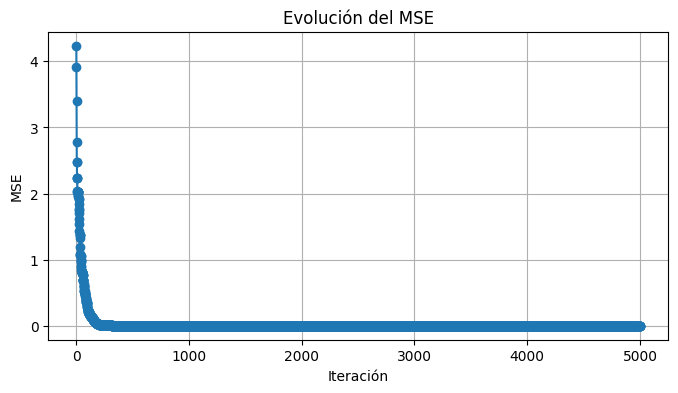

In [ ]:
#Evolucion del valor gbest
plt.figure(figsize=(8, 4))
plt.plot(range(1, iT + 1), historial_valores, marker="o")
plt.title("Evolución del MSE")
plt.xlabel("Iteración")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


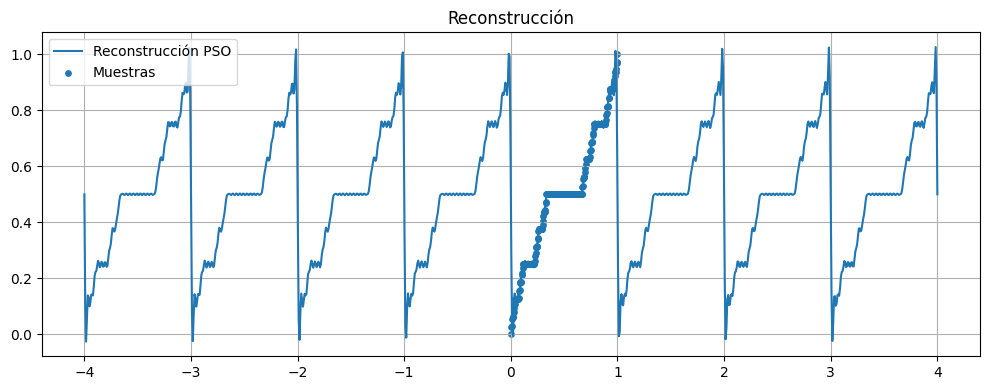

In [ ]:
graficar(gbest, puntos=True)

# **Muestras aleatorias**

In [ ]:
def muestrasAleatorias(funcion, intervalo, nSamples, seed = None):
  if seed is not None:
    np.random.seed(seed)

  #Generar puntos aleatorios en el intervalo
  x = np.random.uniform(intervalo[0], intervalo[1], nSamples)

  #Ordenar para facilitar visualización
  x = np.sort(x)

  #Evaluar función en cada punto
  y = [funcion(xi) for xi in x]

  return x, y

def pso_muestrasAleatorias(funcion, intervalo, nSamples, nArm, iteraciones, numParticulas=50, semilla=None):
  #Muestra aleatoria de la función
  x_rand, y_rand = muestrasAleatorias(funcion, intervalo, nSamples, semilla)

  # Parámetros específicos para esta ejecución
  periodo_local = intervalo[1] - intervalo[0]
  w_local = 2*np.pi/periodo_local


  # Construcción de matriz de funciones base para muestras aleatorias
  def constVectorBase_local(x_data):
    N = len(x_data)
    M = 2 * nArm + 1
    v = np.empty((N, M), dtype=float)
    v[:, 0] = 1.0
    for k in range(1, nArm+1):
      v[:, 2*k-1] = np.cos(k * w_local * x_data)
      v[:, 2*k  ] = np.sin(k * w_local * x_data)
    return v

  vBase_local = constVectorBase_local(x_rand)

  # Función objetivo local
  def funObj_local(pos):
    yPred = np.dot(vBase_local, pos)
    mse = np.mean(np.square(np.subtract(y_rand, yPred)))
    return mse

  # Restricciones de amplitud
  rA_local = np.max(np.abs(y_rand))
  rest_local = [-rA_local, rA_local]

  #Crear partícula local
  def particula_local(restriccion):
    part = {
      "fit": 0,
      "pos": [0 for _ in range(0, 2*nArm + 1)],
      "pbest": [],
      "fitpbest": 0,
      "v": [0 for _ in range(0, 2*nArm + 1)]
    }
    part["pos"][0] = random.uniform(restriccion[0], restriccion[1])

    for i in range(1, 2*nArm, 2):
      part["pos"][i] = random.uniform(restriccion[0], restriccion[1])
      part["pos"][i+1] = random.uniform(restriccion[0], restriccion[1])

    part["fit"] = funObj_local(part["pos"])
    part["pbest"] = part["pos"].copy()
    part["fitpbest"] = part["fit"]
    return part

  # Generación de población inicial
  particulas_local = []
  gbest_local = []
  fitGBest_local = np.inf

  for _ in range(numParticulas):
    p = particula_local(rest_local)
    if p["fit"] < fitGBest_local:
      fitGBest_local = p["fit"]
      gbest_local = p["pos"]

    particulas_local.append(p)

  historial_mse = []

  # Bucle PSO
  for t in range(iteraciones):
    for p in particulas_local:
      for j in range(len(p["v"])):
        r1, r2 = random.random(), random.random()
        p["v"][j] = (
          a * p["v"][j] +
          b1 * r1 * (p["pbest"][j] - p["pos"][j]) +
          b2 * r2 * (gbest_local[j] - p["pos"][j])
        )
        p["pos"][j] = p["pos"][j] + p["v"][j]

        # Restricciones
        if p["pos"][j] < rest_local[0]:
          p["pos"][j] = rest_local[0]
        elif p["pos"][j] > rest_local[1]:
          p["pos"][j] = rest_local[1]

      p["fit"] = funObj_local(p["pos"])

      if p["fit"] < p["fitpbest"]:
        p["pbest"] = p["pos"].copy()
        p["fitpbest"] = p["fit"]

    for p in particulas_local:
      if p["fit"] < fitGBest_local:
        gbest_local = p["pos"].copy()
        fitGBest_local = p["fit"]

    historial_mse.append(fitGBest_local)

  #Retornar resultados completos
  return {
        'x_muestras': x_rand,
        'y_muestras': y_rand,
        'gbest': gbest_local,
        'mse_final': fitGBest_local,
        'historial_mse': historial_mse,
        'vBase': vBase_local,
        'w': w_local,
        'nArm': nArm
        }


In [ ]:
def graficaComparativa(resultados_rand, funcion_real, intervalo):
  #Extraer datos
  x_rand = resultados_rand['x_muestras']
  y_rand = resultados_rand['y_muestras']
  gbest_rand = resultados_rand['gbest']
  w_local = resultados_rand['w']
  nArm_local = resultados_rand['nArm']

  #Dominio para visualización
  x_ext = np.linspace(intervalo[0], intervalo[1], 1000)

  #Reconstrucción de Fourier
  vBase_ext = np.empty((len(x_ext), 2*nArm_local + 1), dtype=float)
  vBase_ext[:, 0] = 1.0

  for k in range(1, nArm_local + 1):
    vBase_ext[:, 2 * k - 1] = np.cos(k * w_local * x_ext)
    vBase_ext[:, 2*k] = np.sin(k * w_local * x_ext)

  y_reconstruida = np.dot(vBase_ext, gbest_rand)

  #Función real para comparación
  try:
    y_real = [funcion_real(xi) for xi in x_ext]
    graficar_real = True
  except:
    graficar_real = False

  #Crear figura
  plt.figure(figsize= (12, 5))

  # Comparación entre reconstrucciones
  plt.subplot(1, 2, 1)
  if graficar_real:
    plt.plot(x_ext, y_real, 'g--', label="Función real", linewidth=1.5, alpha=0.7)
  plt.plot(x_ext, y_reconstruida, 'b-', label="Reconstrucción PSO", linewidth=2)
  plt.scatter(x_rand, y_rand, s=30, c='red', marker='x', label='Muestras aleatorias', zorder=5)
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.title(f'Muestreo aleatorio.\nMSE final: {resultados_rand["mse_final"]:.6f}')
  plt.legend()
  plt.grid(True, alpha=0.3)

  #Evolución del MSE
  plt.subplot(1, 2, 2)
  plt.plot(resultados_rand['historial_mse'], linewidth=2)
  plt.xlabel('Iteración')
  plt.ylabel('MSE')
  plt.title('Convergencia del algoritmo PSO')
  plt.grid(True, alpha=0.3)
  plt.yscale('log')  # Escala logarítmica para mejor visualización

  plt.tight_layout()
  plt.show()



MSE final (muestreo aleatorio): 0.001397
MSE final (muestreo equidistante): 0.002771


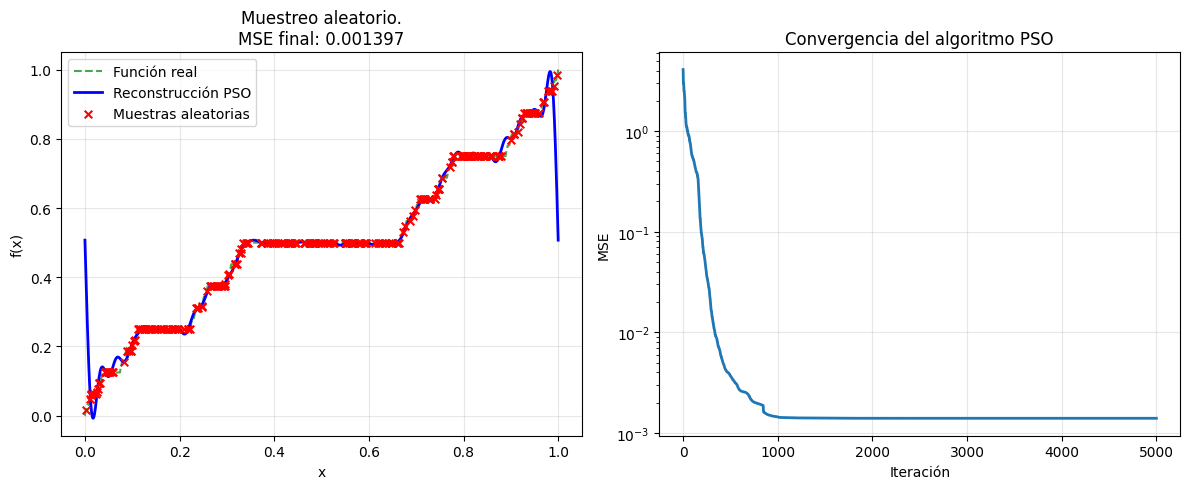

In [ ]:
#Ejemploo de comparación en muestreo

resultados_aleatorio = pso_muestrasAleatorias(
    funcion=f,
    intervalo=intervaloMuestreo,
    nSamples=nSamp,
    nArm=nArmonicos,
    iteraciones=iT,
    numParticulas=N,
    semilla=None  # Para reproducibilidad
)

print(f"MSE final (muestreo aleatorio): {resultados_aleatorio['mse_final']:.6f}")
print(f"MSE final (muestreo equidistante): {fitGBest:.6f}")

# Visualizar resultados
graficaComparativa(
    resultados_aleatorio,
    f,
    intervalo=intervaloMuestreo,
)




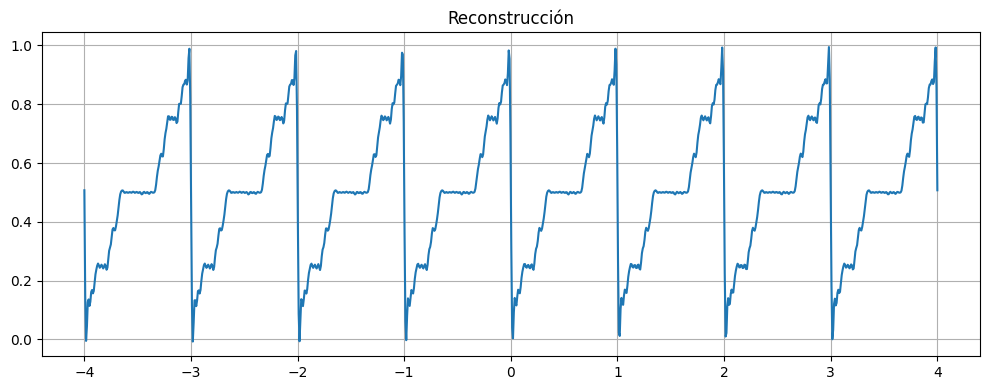

In [ ]:
graficar(resultados_aleatorio["gbest"], puntos=False)

# **Muestras aleatorias y ruidosas**

EXPERIMENTO: ROBUSTEZ DEL PSO ANTE RUIDO

Nivel de ruido: 0%
  MSE final (datos ruidosos): 0.000362
  MSE real (datos limpios): 0.000362

Nivel de ruido: 5%
  MSE final (datos ruidosos): 0.004308
  MSE real (datos limpios): 0.003550

Nivel de ruido: 10%
  MSE final (datos ruidosos): 0.008987
  MSE real (datos limpios): 0.003355

Nivel de ruido: 20%
  MSE final (datos ruidosos): 0.035313
  MSE real (datos limpios): 0.007196

Nivel de ruido: 50%
  MSE final (datos ruidosos): 0.180439
  MSE real (datos limpios): 0.057308

Visualizando resultado con 10% de ruido...


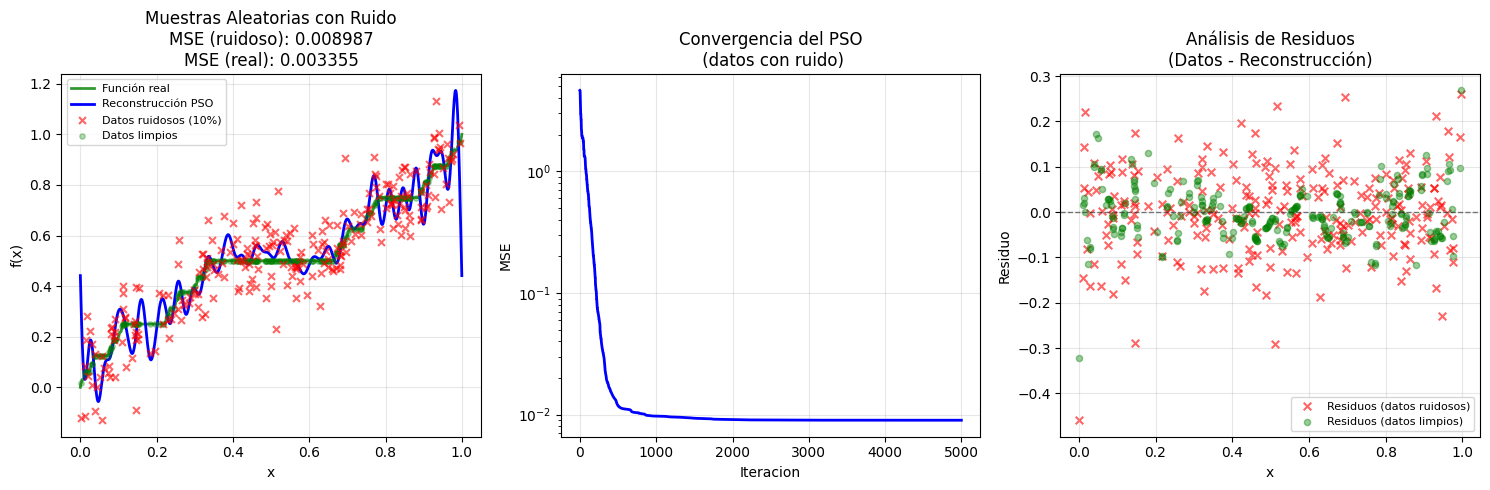

Estadísticas del ruido y reconstrucción
Nivel de ruido aplicado: 10.0%
Desviación estándar del ruido: 0.098682

MSE optimizado (con datos ruidosos): 0.008987
MSE real (con datos limpios): 0.003355
Ratio MSE_real/MSE_ruidoso: 0.3733

Desviación estándar de residuos (limpios): 0.057857
Desviación estándar de residuos (ruidosos): 0.094798
ANÁLISIS: IMPACTO DEL RUIDO EN LA RECONSTRUCCIÓN


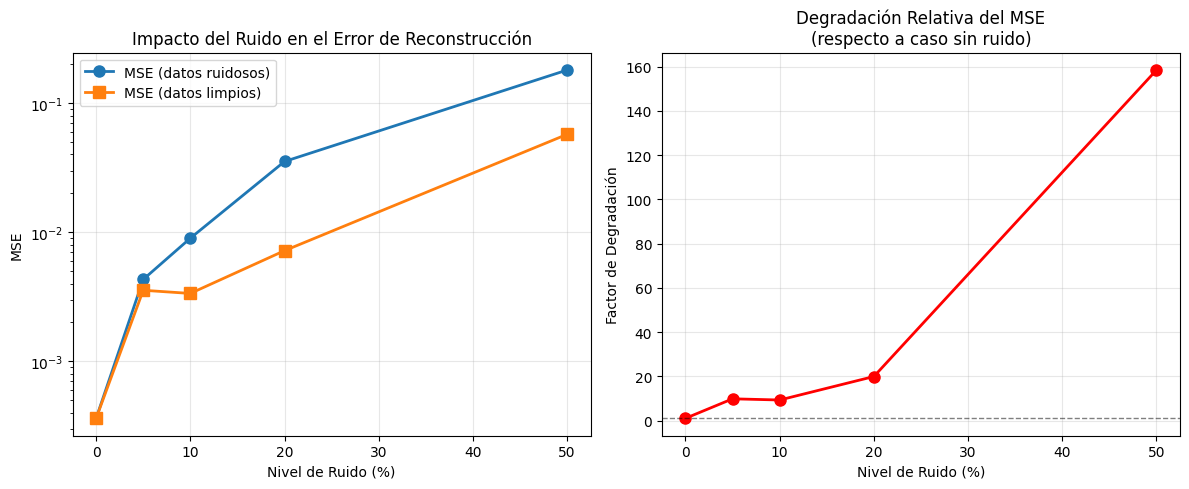


Tabla Resumen:
 Ruido (%) |     MSE Ruidoso |        MSE Real |     Degradación
       0.0 |        0.000362 |        0.000362 |            1.00x
       5.0 |        0.004308 |        0.003550 |            9.82x
      10.0 |        0.008987 |        0.003355 |            9.28x
      20.0 |        0.035313 |        0.007196 |           19.90x
      50.0 |        0.180439 |        0.057308 |          158.47x


In [ ]:
#Muestras aleatorias con ruido
#seed: reproducibilidad
def muestrasAleatoriasRuido(funcion, intervalo, nSamples, nivel_ruido = 0.1, seed = None):
  if seed is not None:
    np.random.seed(seed)

  # Generación aleatoria de puntos en el intervalo
  x = np.random.uniform(intervalo[0], intervalo[1], nSamples)

  #ORdenar para facilitar visualización
  x = np.sort(x)

  # Evaluar función
  y_sinruido = np.array([funcion(xi) for xi in x])

  amp_senal = np.max(np.abs(y_sinruido))

  #Generación de ruido gaussiano
  sigma = nivel_ruido * amp_senal
  ruido = np.random.normal(0, sigma, nSamples)

  #Ruido a las muestras
  y_ruido = y_sinruido + ruido
  return x, y_sinruido, y_ruido

def pso_muestrasAleatorias_Ruido(funcion, intervalo, nSamples, nArm, iteraciones, nivel_ruido=nruido, numParticulas=50, semilla=None):
  #Generar muestras con ruido
  x_rand, y_sinruido, y_ruido = muestrasAleatoriasRuido(funcion, intervalo, nSamples, nivel_ruido, semilla)
  #Parámetros
  periodo_local = intervalo[1] - intervalo[0]
  w_local = 2*np.pi/periodo_local

  #Construcción de matriz de funciones base

  def constVectorBase_local(x_data):
    N = len(x_data)
    M = 2 * nArm + 1
    v = np.empty((N,M), dtype=float)
    v[:, 0] = 1.0
    for k in range(1, nArm + 1):
      v[:, 2* k-1] = np.cos(k * w_local * x_data)
      v[:, 2* k] = np.sin(k * w_local * x_data)
    return v
  vBase_local = constVectorBase_local(x_rand)

  # Función objetivo: minimiza error con respecto a datos ruidoss
  def funObj_local(pos):
    yPred = np.dot(vBase_local, pos)
    mse = np.mean(np.square(np.subtract(y_ruido, yPred)))
    return mse

  #Función para calcular MSE real (con respecto a datos limpios)
  # Esto nos permite evaluar qué tan bien funciona el algoritmo
  def funObj_real(pos):
    yPred = np.dot(vBase_local, pos)
    mse = np.mean(np.square(np.subtract(y_sinruido, yPred)))
    return mse

  #Restricciones
  rA_local = np.max(np.abs(y_ruido))
  rest_local = [-rA_local, rA_local]

  # Crear partícula local
  def particula_local(restriccion):
    part = {
      "fit": 0,
      "pos": [0 for _ in range(0, 2*nArm + 1)],
      "pbest": [],
      "fitpbest": 0,
      "v": [0 for _ in range(0, 2*nArm + 1)]
    }
    part["pos"][0] = random.uniform(restriccion[0], restriccion[1])
    for i in range(1, 2*nArm, 2):
      part["pos"][i] = random.uniform(restriccion[0], restriccion[1])
      part["pos"][i+1] = random.uniform(restriccion[0], restriccion[1])
    part["fit"] = funObj_local(part["pos"])
    part["pbest"] = part["pos"].copy()
    part["fitpbest"] = part["fit"]
    return part

  # Generación de población inicial
  particulas_local = []
  gbest_local = []
  fitGBest_local = np.inf

  for _ in range(numParticulas):
    p = particula_local(rest_local)
    if p["fit"] < fitGBest_local:
      fitGBest_local = p["fit"]
      gbest_local = p["pos"]
    particulas_local.append(p)

  historial_mse = []

  # Bucle PSO
  for t in range(iteraciones):
    for p in particulas_local:
      for j in range(len(p["v"])):
        r1, r2 = random.random(), random.random()
        p["v"][j] = (
          a * p["v"][j] +
          b1 * r1 * (p["pbest"][j] - p["pos"][j]) +
          b2 * r2 * (gbest_local[j] - p["pos"][j])
        )
        p["pos"][j] = p["pos"][j] + p["v"][j]

        # Restricciones
        if p["pos"][j] < rest_local[0]:
          p["pos"][j] = rest_local[0]
        elif p["pos"][j] > rest_local[1]:
          p["pos"][j] = rest_local[1]

      p["fit"] = funObj_local(p["pos"])

      if p["fit"] < p["fitpbest"]:
        p["pbest"] = p["pos"].copy()
        p["fitpbest"] = p["fit"]

    for p in particulas_local:
      if p["fit"] < fitGBest_local:
        gbest_local = p["pos"].copy()
        fitGBest_local = p["fit"]

    historial_mse.append(fitGBest_local)

  # Calcular MSE real (con respecto a datos limpios)
  mse_real = funObj_real(gbest_local)

  # Retornar resultados completos
  return {
    'x_muestras': x_rand,
    'y_limpio': y_sinruido,
    'y_ruidoso': y_ruido,
    'gbest': gbest_local,
    'mse_final': fitGBest_local,  # MSE con datos ruidosos
    'mse_real': mse_real,          # MSE con datos limpios (métrica real)
    'historial_mse': historial_mse,
    'vBase': vBase_local,
    'w': w_local,
    'nArm': nArm,
    'nivel_ruido': nivel_ruido
  }

def graficaComparativaRuido(resultados_ruido, funcion_real, intervalo):
    # Extraer datos
    x_rand = resultados_ruido['x_muestras']
    y_limpio = resultados_ruido['y_limpio']
    y_ruidoso = resultados_ruido['y_ruidoso']
    gbest_rand = resultados_ruido['gbest']
    w_local = resultados_ruido['w']
    nArm_local = resultados_ruido['nArm']
    nivel_ruido = resultados_ruido['nivel_ruido']

    # Dominio para visualización
    x_ext = np.linspace(intervalo[0], intervalo[1], 1000)

    # Reconstrucción de Fourier
    vBase_ext = np.empty((len(x_ext), 2*nArm_local + 1), dtype=float)
    vBase_ext[:, 0] = 1.0
    for k in range(1, nArm_local + 1):
      vBase_ext[:, 2*k-1] = np.cos(k * w_local * x_ext)
      vBase_ext[:, 2*k] = np.sin(k * w_local * x_ext)

    y_reconstruida = np.dot(vBase_ext, gbest_rand)

    # Función real
    try:
      y_real = [funcion_real(xi) for xi in x_ext]
      graficar_real = True
    except:
      graficar_real = False

    # Crear figura con 3 subplots
    fig = plt.figure(figsize=(15, 5))


    #Comparar reconstrucción
    plt.subplot(1, 3, 1)
    if graficar_real:
      plt.plot(x_ext, y_real, 'g-', label='Función real', linewidth=2, alpha=0.8)
    plt.plot(x_ext, y_reconstruida, 'b-', label='Reconstrucción PSO', linewidth=2)
    plt.scatter(x_rand, y_ruidoso, s=25, c='red', marker='x',
                label=f'Datos ruidosos ({nivel_ruido*100:.0f}%)', zorder=5, alpha=0.6)
    plt.scatter(x_rand, y_limpio, s=15, c='green', marker='o',
                label='Datos limpios', zorder=4, alpha=0.3)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'Muestras Aleatorias con Ruido\nMSE (ruidoso): {resultados_ruido["mse_final"]:.6f}\nMSE (real): {resultados_ruido["mse_real"]:.6f}')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)


    #Evolución del MSE
    plt.subplot(1, 3,2)
    plt.plot(resultados_ruido['historial_mse'], linewidth=2, color='blue')
    plt.xlabel('Iteracion')
    plt.ylabel('MSE')
    plt.title('Convergencia del PSO\n (datos con ruido)')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    #Analisis de residuos

    plt.subplot(1, 3, 3)

    # Reconstrucción en puntos de muestreo
    vBase_muestras = np.empty((len(x_rand), 2*nArm_local + 1), dtype=float)
    vBase_muestras[:, 0] = 1.0
    for k in range(1, nArm_local + 1):
      vBase_muestras[:, 2*k-1] = np.cos(k * w_local * x_rand)
      vBase_muestras[:, 2*k] = np.sin(k * w_local * x_rand)
    y_recons_muestras = np.dot(vBase_muestras, gbest_rand)

    # Calcular residuos
    residuos_ruidosos = y_ruidoso - y_recons_muestras
    residuos_limpios = y_limpio - y_recons_muestras

    plt.scatter(x_rand, residuos_ruidosos, s=30, c='red', marker='x',
              label='Residuos (datos ruidosos)', alpha=0.6)
    plt.scatter(x_rand, residuos_limpios, s=20, c='green', marker='o',
              label='Residuos (datos limpios)', alpha=0.4)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('Residuo')
    plt.title('Análisis de Residuos\n(Datos - Reconstrucción)')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Estadísticas del ruido y reconstrucción")
    print(f"Nivel de ruido aplicado: {nivel_ruido*100:.1f}%")
    print(f"Desviación estándar del ruido: {np.std(y_ruidoso - y_limpio):.6f}")
    print(f"\nMSE optimizado (con datos ruidosos): {resultados_ruido['mse_final']:.6f}")
    print(f"MSE real (con datos limpios): {resultados_ruido['mse_real']:.6f}")
    print(f"Ratio MSE_real/MSE_ruidoso: {resultados_ruido['mse_real']/resultados_ruido['mse_final']:.4f}")
    print(f"\nDesviación estándar de residuos (limpios): {np.std(residuos_limpios):.6f}")
    print(f"Desviación estándar de residuos (ruidosos): {np.std(residuos_ruidosos):.6f}")

print("EXPERIMENTO: ROBUSTEZ DEL PSO ANTE RUIDO")

# Probar con diferentes niveles de ruido
niveles_ruido = [0.0, 0.05, 0.1, 0.2, 0.5]
resultados_experimento = []

for nivel in niveles_ruido:
  print(f"\nNivel de ruido: {nivel*100:.0f}%")
  resultado = pso_muestrasAleatorias_Ruido(
      funcion=f,
      intervalo=intervaloMuestreo,
      nSamples=nSamp,
      nArm=nArmonicos,
      iteraciones=iT,
      nivel_ruido=nivel,
      numParticulas=N,
      semilla=None
  )
  resultados_experimento.append(resultado)
  print(f"  MSE final (datos ruidosos): {resultado['mse_final']:.6f}")
  print(f"  MSE real (datos limpios): {resultado['mse_real']:.6f}")

# Visualizar caso con ruido moderado (10%)
print("\nVisualizando resultado con 10% de ruido...")
resultado_10 = resultados_experimento[2]  # nivel_ruido = 0.1
graficaComparativaRuido(
    resultado_10,
    f,
    intervalo=intervaloMuestreo,
)

# ANÁLISIS COMPARATIVO: EFECTO DEL RUIDO
print("ANÁLISIS: IMPACTO DEL RUIDO EN LA RECONSTRUCCIÓN")

# Crear gráfica del impacto del ruido
plt.figure(figsize=(12, 5))

# Subplot 1: MSE vs Nivel de Ruido
plt.subplot(1, 2, 1)
mse_ruidosos = [r['mse_final'] for r in resultados_experimento]
mse_reales = [r['mse_real'] for r in resultados_experimento]

plt.plot([n*100 for n in niveles_ruido], mse_ruidosos, 'o-',
         label='MSE (datos ruidosos)', linewidth=2, markersize=8)
plt.plot([n*100 for n in niveles_ruido], mse_reales, 's-',
         label='MSE (datos limpios)', linewidth=2, markersize=8)
plt.xlabel('Nivel de Ruido (%)')
plt.ylabel('MSE')
plt.title('Impacto del Ruido en el Error de Reconstrucción')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Subplot 2: Degradación relativa
plt.subplot(1, 2, 2)
degradacion = [(r['mse_real'] / resultados_experimento[0]['mse_real'])
               for r in resultados_experimento]
plt.plot([n*100 for n in niveles_ruido], degradacion, 'o-',
         linewidth=2, markersize=8, color='red')
plt.xlabel('Nivel de Ruido (%)')
plt.ylabel('Factor de Degradación')
plt.title('Degradación Relativa del MSE\n(respecto a caso sin ruido)')
plt.grid(True, alpha=0.3)
plt.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla Resumen:")
print(f"{'Ruido (%)':>10} | {'MSE Ruidoso':>15} | {'MSE Real':>15} | {'Degradación':>15}")
for i, nivel in enumerate(niveles_ruido):
  r = resultados_experimento[i]
  deg = r['mse_real'] / resultados_experimento[0]['mse_real']
  print(f"{nivel*100:>10.1f} | {r['mse_final']:>15.6f} | {r['mse_real']:>15.6f} | {deg:>15.2f}x")


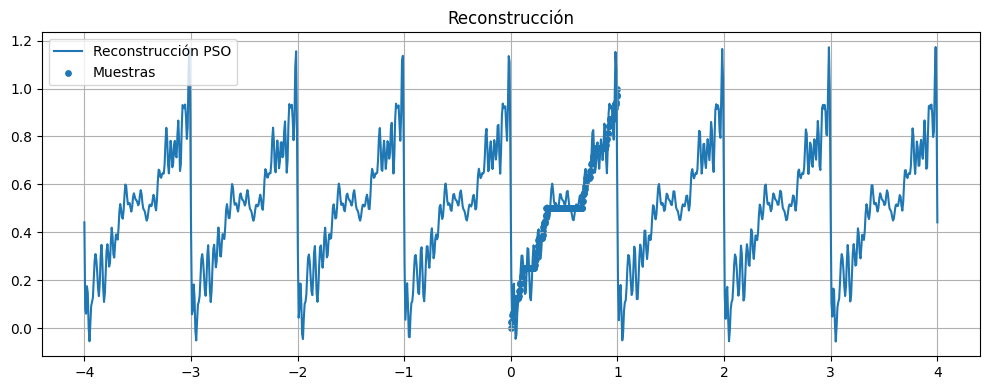

In [ ]:
graficar(resultado=resultados_experimento[2]["gbest"])